In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

In [2]:
#https://www.ic.unicamp.br/~helio/videos_mp4/
video_url = "https://www.ic.unicamp.br/~helio/videos_mp4/indi009.mpg"
# video_url = "https://www.ic.unicamp.br/~helio/videos_mp4/UGS09.mpg"

#https://www.ic.unicamp.br/~helio/disciplinas/MO443/trabalho3.pdf

In [3]:
video = cv2.VideoCapture(video_url)

In [4]:
video_frames = []
while(True):
    # Capture frame-by-frame
    ret, frame = video.read()
    #print cap.isOpened(), ret
    if frame is not None:
        # Display the resulting frame
        video_frames.append(frame)
    else:
        print ("Frame is None")
        break

# When everything done, release the capture
# video.release()

Frame is None


In [6]:
def convert2gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

In [7]:
def convert2BGR(image):
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return color_image

In [8]:
def convert2HSV(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return hsv_image

In [9]:
def convert_from_HSV(image):
    color_image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    return color_image

In [10]:
hsv_video_frames = np.array(list(map(convert2HSV, video_frames)))

In [11]:
gray_video_frames = hsv_video_frames[:,:,:,2]

In [13]:
gray_video_frames[0].shape

(240, 320)

## Diferença entre pixels


In [14]:
def diff_betweens_pixels(gray_video_frames, T1=64, T2_tax = 0.8):
    #First threshould

    #Verify if 80% of pixels was changed
    T2 = int(gray_video_frames[0].shape[0] * gray_video_frames[0].shape[1] * T2_tax)

    #List with the diff between the frames
    list_pixels_diff = []

    #List with indexs where the pixel pass the secong threshould
    list_over_T2 = []

    print(range(len(gray_video_frames)-1))
    for frame in tqdm(range(len(gray_video_frames)-1)):
    
        list_pixels_diff.append(np.unique(gray_video_frames[frame] - gray_video_frames[frame+1] > T1, return_counts=True)[1][1])
    
        if list_pixels_diff[frame] > T2:
            list_over_T2.append(frame)

    plot_hist_diff(list_pixels_diff, T2)

    return list_over_T2

In [15]:
def plot_hist_diff(list_pixels_diff, T2):
    plt.plot(np.arange(len(list_pixels_diff)), list_pixels_diff)
    plt.hlines(T2, 0, len(video_frames), colors='red', linestyles='solid')
    plt.xlabel("Nº do frame")
    plt.ylabel("Qnt. de pixels com diferença superior a T1")


## Diferença entre Blocos

In [16]:
def diff_betweens_boxes(gray_video_frames, T1_limiar=10, T2_limit=0.9, box_size=8):
    #Limiar to MSE
    T1 = len(gray_video_frames) / T1_limiar
    
    # T2 = len(gray_video_frames) * T2_limit

    #List of frames that transpase the threshould T1
    list_pixels_diff = []

    #Loop in each frame
    for frame in tqdm(range(len(gray_video_frames)-1)):
        #Loop in rows
        for row in range(int(gray_video_frames[frame].shape[0]/box_size)):
            #Loop in collumns
            for col in range(int(gray_video_frames[frame].shape[1]/box_size)):
                #Get the box of actual frame and next, cast them in int to subtract
                actual_frame = gray_video_frames[frame, row:row+8, col:col+8].astype(int)
                next_frames = gray_video_frames[frame+1, row:row+8, col:col+8].astype(int)

                #Calculate MSE between the boxs
                norm = (1/(box_size*box_size))
                box_diff =  norm * (np.sum(np.abs(actual_frame - next_frames) ** 2))

                if box_diff > T1:
                    list_pixels_diff.append(frame)

    #List with diff pixel bigger than T2
    list_diff_pixels_MSE = []
    dict_pixels_diff = Counter(list_pixels_diff)

    T2 = max(dict_pixels_diff.values())*T2_limit

    #Loop to count how many boxes each frame have with diff.
    for disct_frame, value in dict_pixels_diff.items():
        if value > T2:
            list_diff_pixels_MSE.append(disct_frame)

    #Plot the distribution of MSE in frames
    plot_hist_diff(np.array(list(dict_pixels_diff.values())), T2)

    return list_diff_pixels_MSE

## Selecionando *Key frames*

In [17]:
def get_colorfull_frames(list_of_frames, number_of_repeats=50):
    # key_frames = np.array(gray_video_frames)[list_over_T2]
    key_frames = np.array(hsv_video_frames[list_of_frames])

    #Repeat the values of key frames to create a video
    key_frames_pre_video = np.repeat(key_frames, number_of_repeats, axis=0)

    #Convert frames to BGR
    colorful_video_frames = np.array(list(map(convert_from_HSV, key_frames_pre_video)))

    return colorful_video_frames

100%|██████████| 502/502 [00:13<00:00, 38.46it/s]


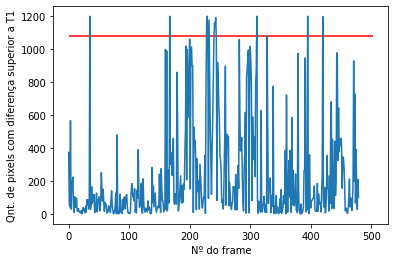

In [18]:
# list_diff_pixels = diff_betweens_pixels(gray_video_frames, T1=64, T2_tax = 0.8)

list_diff_pixels = diff_betweens_boxes(gray_video_frames, box_size=8)

#Get the sequencia of color full frames
colorful_video_frames = get_colorfull_frames(list_diff_pixels)

In [19]:
def save_video(colorful_video_frames, video_name='summary_video'):

    size = gray_video_frames[0].shape
    # duration = 2
    fps = 25
    out = cv2.VideoWriter(f'{video_name}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]))

    for i in range(len(colorful_video_frames)):
        data = colorful_video_frames[i]
        out.write(data)
    out.release()

In [20]:
save_video(colorful_video_frames)